In [126]:
%%html
<style>
.cell, .CodeMirror pre{ 
    font-size: 200%;
    line-height: 150%;
}
</style>

# Principal Component Analysis

The Viola Jones face detector allows us to find regions of images which contain faces. 
We now want to apply further analysis to these patches to perform tasks such as face recognition.
To do this we need to apply some sort of machine learning algorithm to the image patches, and these typically expect data to be presented as a set values for each of several variables.
A direct way to do this for images is to view each pixel as a varaible, and the intenstity as the sample's value for that variable.

This approach has a few drawbacks, however:
* There are a lot of variables - a 100 pixel square image patch has 10,000 dimensions
* Such high dimensional spaces are hard to think about and visualise
* The pixel values are not indepenedent - neighbouring pixels tend to have similar values, so there's a lot of redundant information

To reduce these problems we can apply some sort of *dimensionality reduction* to transform the data to a lower-dimensional representation. 
One of the most common methods for this is *principal component analysis*, or *PCA*.

## A Simple Example

Before we get to images and thousands of dimensions, we'll look at PCA in a simpler case. 
Suppose we have some 2D data, so we have two measurements for each sample. 
These might be the height and weight of people, grades of students in two different papers, the population and area of cities, or whatever. 
We'll assume that the data is stored in a matrix with one row for each data point and one column for each observation.

Our data matrix with \\(n\\) samples is

\\[
D = \begin{bmatrix}
x_1 & y_1 \\
x_2 & y_2 \\
\vdots & \vdots\\
x_n & y_n
\end{bmatrix}
\\]

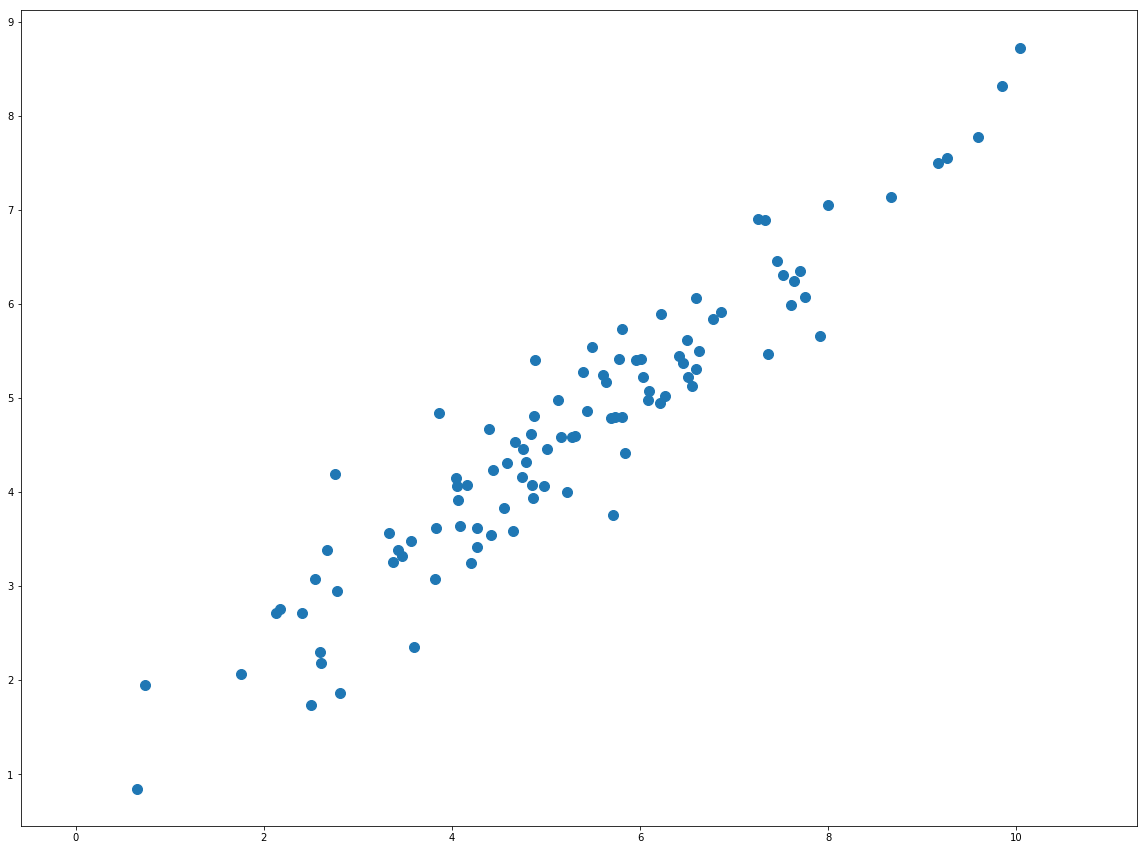

In [127]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Generate some numbers distributed around the line y = 0.7 x
n = 100 # Number of samples to generate
d = 2   # Dimensionality of samples
D = numpy.zeros([n, d])
D[:,0] = numpy.random.normal(5, 2, n)
D[:,1] = 0.7*D[:,0] + numpy.random.normal(1, 0.5, n)

# Scatter plot
plt.figure(figsize=(20,15))
plt.axis('equal')
plt.scatter(D[:,0], D[:,1], 100)

## Step 1 - Subtract the Mean

The first step in PCA is to transform the data so that it is centred around the origin. 
We compute the mean (average) of the data, and subtract it from each row in the matrix \\(D\\) to give us some zero-mean data, \\(Z = D - M \\), where \\(M\\) is a \\(n \times d\\) matrix where every row is the mean of the data.

Mean value = [ 5.25719203  4.65027312]


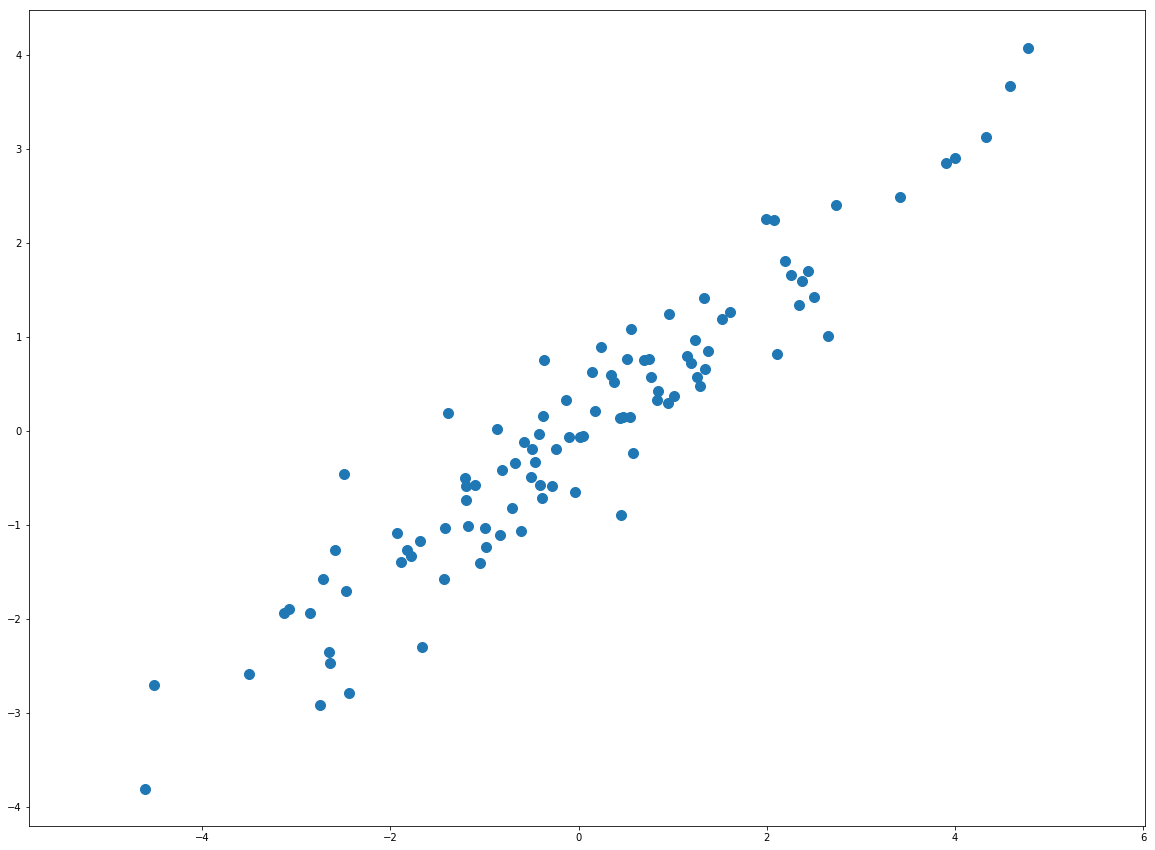

In [128]:
# Compute mean along first axis (average the columns)
mean = numpy.mean(D, 0)
print("Mean value = " + str(mean))

# Subtract the mean from each row - numpy is smart about this
Z = D - mean

plt.figure(figsize=(20,15))
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], 100)

## Step 2 - compute the covariance

Next we need to compute the covariance of the data. 
This is easily computed from our sample as
\\[
C = \frac{1}{n-1}Z^TZ
\\]

The diagonal elements of the covaraince matrix are the variance (squared standard deviation) in each of the component. 
The off-diagonal entries give the co-variance, which says how the values are related. 
A positive co-variance means that if one value (\\(x\\), say) increases then the other (\\(y\\)) tends to increase as well.
A negative co-variance means that if one value increases the other generally decreases.
A zero co-variance means that the two values are not dependent on one another.

**Question: Why do we divide by \\(n-1\\) rather than \\(n\\) when computing the covariance?**

In [129]:
C = numpy.matmul(numpy.transpose(Z), Z) / (n-1)

print("Covariance matrix:")
print(C)

Covariance matrix:
[[ 3.72187131  2.70620179]
 [ 2.70620179  2.18924438]]


## Step 3 - Compute the Eigenvalues and Eigenvectors of \\(C\\)

The main step in PCA is finding the eigenvalues and eigenvectors of the covariance matrix, \\(C\\).
An *eigenvector* of \\(C\\) is a vector that when multiplied by \\(C\\) doesn't change direction.
It might, however, get longer or shorter, so this can be expressed as
\\[
Cv = \lambda v
\\]
where \\(v\\) is the *eigenvector* and \\(\lambda\\) is a scaling factor, called the *eigenvalue*.
The eigenvectors of the covariance matrix have a number of properties that we'll make use of:
* The eigenvector corresponding to the largest eigenvalue points along the direction of greatest spread in the data. This is the key to their use in dimensionality reduction.
* The eigenvectors are orthogonal to one another. This means that they are at right angles to one another, and so represent independent axes in the data.
* If \\(v\\) is an eigenvalue of \\(C\\) then so is \\(kv\\) for any scalar \\(k\\). This means that \\(v\\) isn't unique, but we generaly choose to have eigenvectors with unit length.
* The eigenvalues associated with each eigenvector tell us how much of the variation in the data is along that axis. They are the statistical variance, which means that the square root of the eigenvalue is the standard deviation.

These properties mean that we can use the eigenvectors to form a new set of axes (a *basis*) for the data, such that there is an ordering of the axes from the most to least significant.
These axes are the principal components of the data, and when we talk about the *first principal component* or *first eigenvector* we mean the eigenvector (or new axis) corrresponding to the largest eigenvalue.

The details of eigenvectors/values and their computation are a bit more than we have time for, but fortunately this is built in to all good linear algebra packages.
Most of these packages will return the eigenvalues and vectors in descending order, and often there are options to compute just the first \\(k\\) eigenthings.

[ 0.97581679  0.02418321]


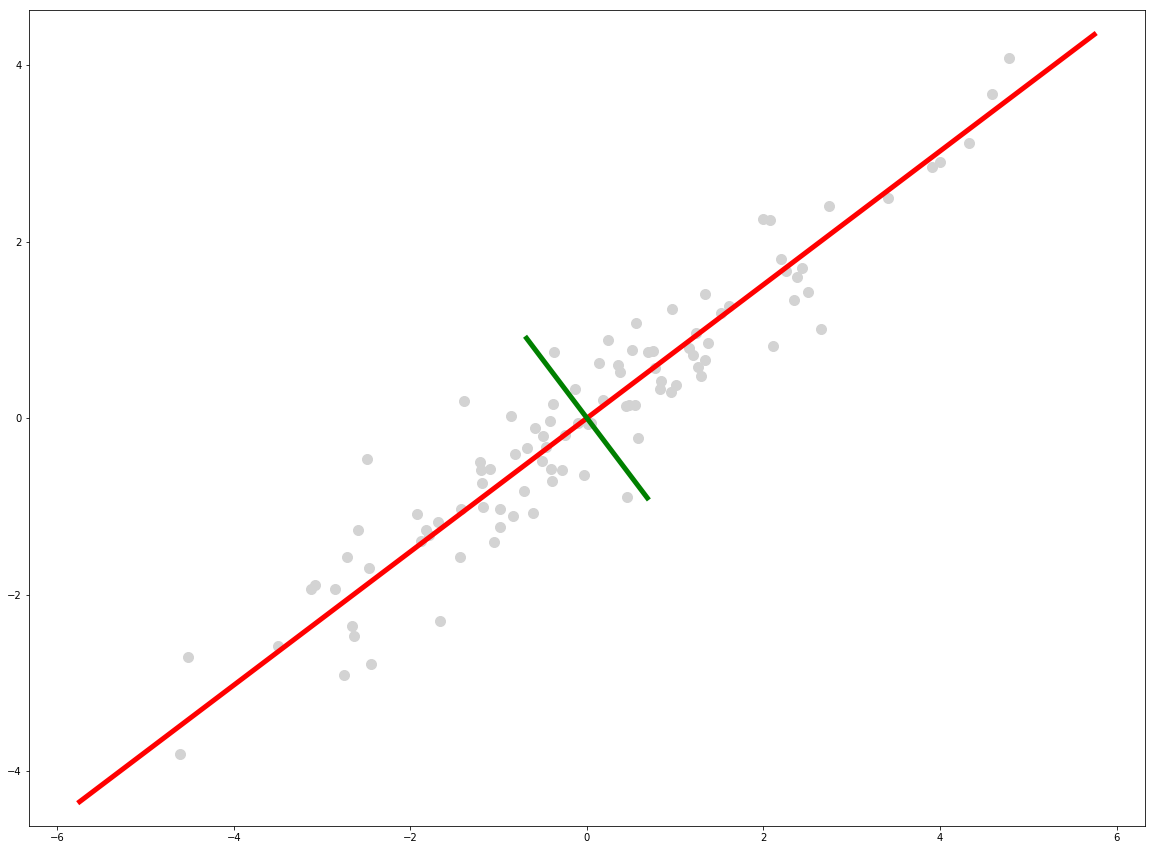

In [134]:
eVal, eVec = numpy.linalg.eig(C)

print(eVal/sum(eVal)) # Proportion of spread on each axis

plt.figure(figsize=(20,15))
plt.axis('equal')
# Plot the data
plt.scatter(Z[:,0], Z[:,1], 100, c='lightgray')
# First eigenvector, scaled by standard deviation
scale = 3 * numpy.sqrt(eVal[0])
plt.plot([-scale*eVec[0,0],scale*eVec[0,0]], 
         [-scale*eVec[1,0],scale*eVec[1,0]], 
         '-r', linewidth=5)
# Second eigenvector, scaled by standard deviatin
scale = 3 * numpy.sqrt(eVal[1])
plt.plot([-scale*eVec[0,1],scale*eVec[0,1]], 
         [-scale*eVec[1,1],scale*eVec[1,1]], 
         '-g', linewidth=5)


## Step 4 - Dimensionality Reduction

To reduce the dimensionality of the data, we can start by transforming the data into the axes defined by the eigenvectors.
Remember, our original data is in the matrix \\(D\\), and we've got a zero-mean version in \\(Z\\). 
We can transform \\(Z\\) into the eigenvector axes as
\\[
E = ZV,
\\]
where \\(V\\) is the matrix where each column is an eigenvector.

To transform back to the original axes, we just use
\\[
Z = EV^{-1},
\\]
and the inverse is easy to compute because the matrix \\(V\\) is orthogonal so \\(V^{-1} = V^T\\) (**NOTE:** this is not true for matrices in general).

We can then reduce the dimensionality by zero-ing out columns of \\(V\\) (rows of \\(V^{-1}\\)) corresponding to small eigenvalues.

**Question: Why do we zero out *rows* of \\(V^{-1}\\), when the columns of \\(V\\) are the eigenvectors?**

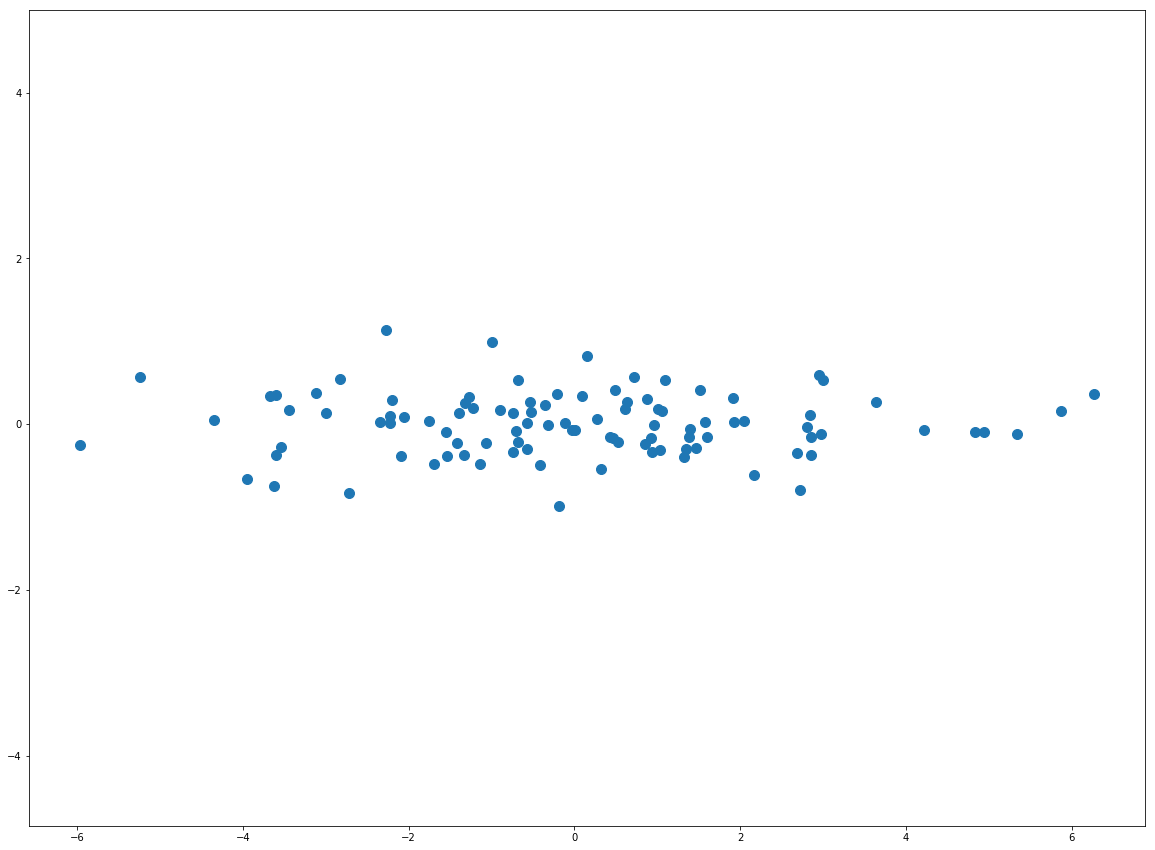

In [131]:
E = numpy.matmul(Z, eVec)

plt.figure(figsize=(20,15))
plt.axis('equal')
plt.scatter(E[:,0], E[:,1], 100)

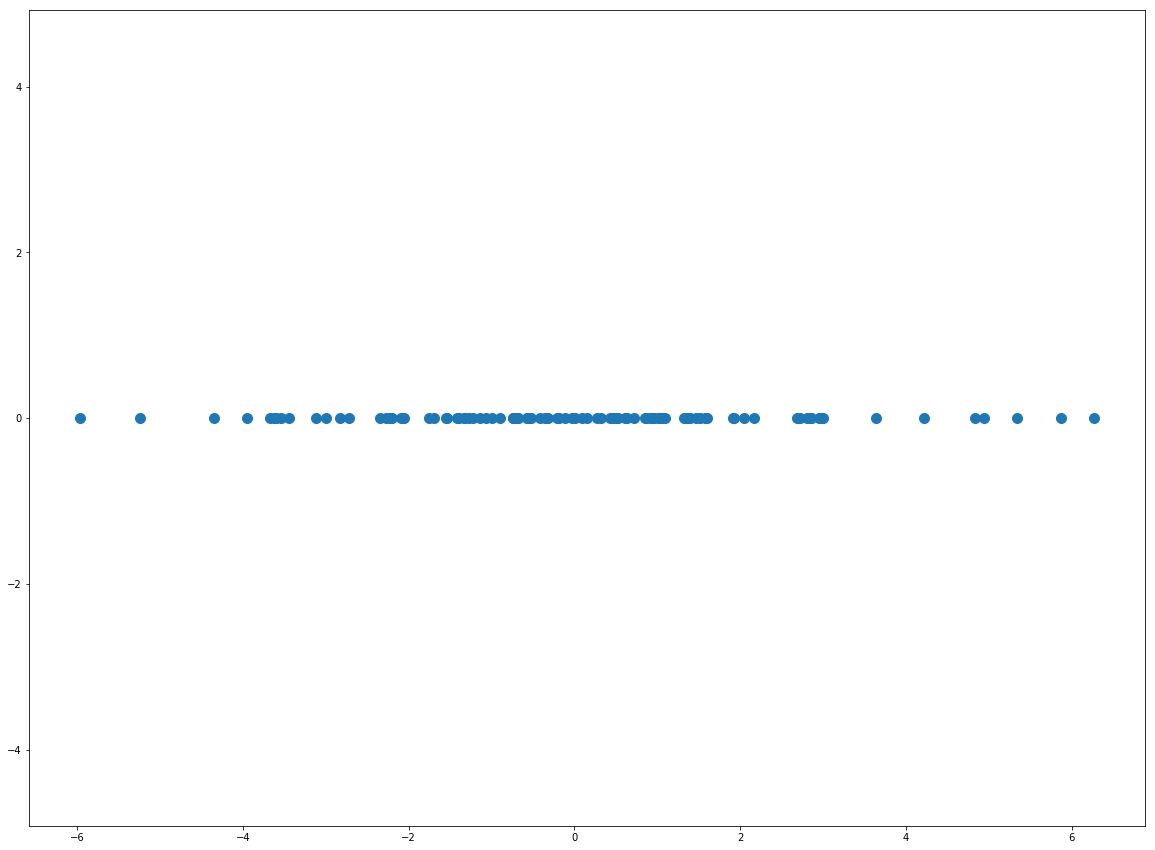

In [132]:
Vreduced = eVec
Vreduced[:,1] = 0

Ereduced = numpy.matmul(Z, Vreduced)

plt.figure(figsize=(20,15))
plt.axis('equal')
plt.scatter(Ereduced[:,0], Ereduced[:,1], 100)

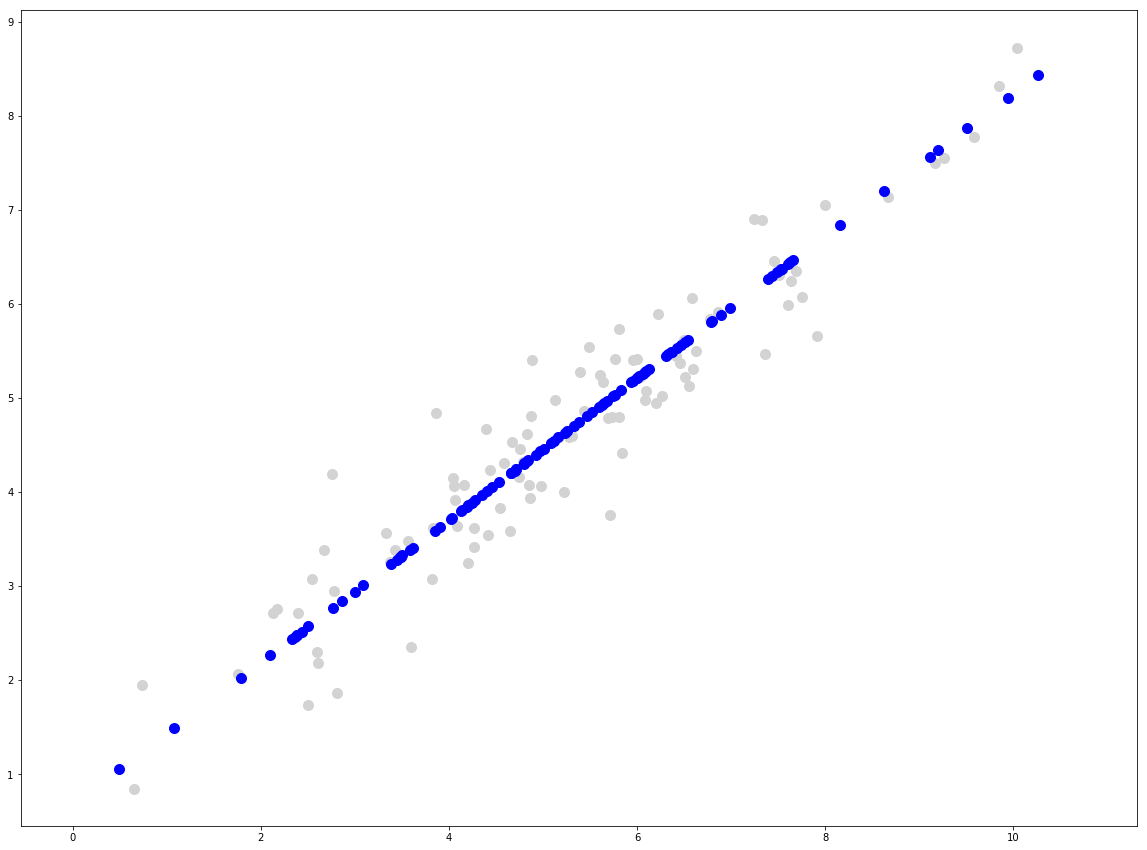

In [135]:
Zreduced = numpy.matmul(Ereduced, numpy.transpose(eVec))
Dreduced = Zreduced + mean

plt.figure(figsize=(20,15))
plt.axis('equal')
plt.scatter(D[:,0], D[:, 1], 100, c='lightgray')
plt.scatter(Dreduced[:,0], Dreduced[:,1], 100, c='blue')

** Question: Sometimes the data might be flipped around when you transform it to/from the eigenvector axes. Why can this happen? **

### How many dimensions to keep?

In the example above, we've kept just one dimension but preserved a lot of the variation in the data set. 
In more realistic cases we start with a higher-dimensional, and need to choose how many dimensions to keep.
We can do this on the basis of the eigenvalues.
The eigenvalues represent the variance along each axis, so we can choose to keep some percentage of the overall variance.
The 2D example has just two eigenvalues, \\(\lambda_1\\) and \\(\lambda_2\\), so the percentage of variance kept by projecting onto the first eigenvector is
\\[
\frac{\lambda_1}{\lambda_1 + \lambda_2} \times 100\%.
\\]

More generally, if we have \\(d\\) dimensions but keep only \\(k\\) eigenvectors, the proportion of variance kept is
\\[
\frac{\lambda_1 + \lambda_2 + \dots + \lambda_k}{\lambda_1 + \lambda_2 + \dots + \lambda_d} \times 100\%,
\\]
and we can choose \\(k\\) to keep a specific proportion of the data (90%, say).